<a href="https://colab.research.google.com/github/yh-cgqz/Skin-Lesion-Classification-ISIC2019/blob/main/Skin_Lesion_Classification_ISIC2019_MobileNetViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lesion Classification using MobileNet-ViT and Comparative Models (ISIC 2019)

This notebook implements a deep learning pipeline to classify skin lesion images from the ISIC 2019 dataset. The objective is to develop and evaluate a hybrid model combining MobileNet and Vision Transformer (ViT), and compare its performance against pre-trained models including ResNet-50, Inception, and ShuffleNet.

The models will be evaluated using various metrics such as accuracy, precision, recall, F1-score, AUC-ROC, confusion matrix, and Grad-CAM visualizations to understand interpretability. The goal is to improve the diagnostic performance and reliability of AI-assisted dermatology tools.


| Section | Section Title | Key Objectives |
|---|---|---|
| 1 | Introduction (Markdown) | Define the problem, dataset, and approach |
| 2 | Mount Google Drive & Set Paths | Connect to Google Drive, define paths |
| 3 | Unzip and Organize Dataset | Automatically unzip if necessary |
| 4 | Load Libraries | Load required libraries for modeling and visualization |
| 5 | Load CSVs (Labels and Metadata) | Read in the ground truth and metadata CSVs |
| 6 | Preview Dataset | Display random image samples and inspect CSVs |
| 7 | Class Distribution and Imbalance Visualization | Plot class counts, identify imbalance |
| 8 | Handle Class Imbalance | Compute and apply class weights |
| 9 | Preprocessing and Data Augmentation | Resize, normalize, augment images |
| 10 | Train-Test-Validation Split | Split dataset properly with stratification |
| 11 | Build Baseline Model: ResNet-50 | Use transfer learning with pre-trained ResNet-50 |
| 12 | Build Hybrid Model: MobileNet + ViT | Construct and train a hybrid MobileNet-ViT architecture |
| 13 | Build Comparative Models: Inception & EfficientNet | Fine-tune additional pre-trained models with custom layers |
| 14 | Model Evaluation & Metrics | Evaluate all models using: Accuracy, Precision, Recall, F1, AUC-ROC, TPR/TNR, Confusion Matrix |
| 15 | Grad-CAM & Interpretability | Generate Grad-CAM heatmaps for interpretability |
| 16 | Prediction Visualization | Show predictions on selected validation images |
| 17 | Model Comparison and Discussion | Compare metrics across models, discuss results |
| 18 | Save Models and Wrap-up | Save trained models for deployment or reuse |

In [ ]:
# Install required packages
!pip install -q vit-keras
!pip install -q grad-cam
!pip install -q seaborn
!pip install -q opencv-python
!pip install -q scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s

# 1. Mount Google Drive

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Set Data Paths

In [ ]:
import os

# Base directory
base_path = '/content/drive/MyDrive/ISIC_2019'

# Paths to files and folders
zip_path = os.path.join(base_path, 'ISIC_2019_Training_Input.zip')
image_dir = os.path.join(base_path, 'ISIC_2019_Training_Images', 'ISIC_2019_Training_Input')
label_csv = os.path.join(base_path, 'ISIC_2019_Training_GroundTruth.csv')
meta_csv = os.path.join(base_path, 'ISIC_2019_Training_Metadata.csv')

# 3. Unzip Images if Not Already Unzipped

In [ ]:
import zipfile

if not os.path.exists(image_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(image_dir)
    print("Image folder unzipped.")
else:
    print("Image folder already exists.")

Image folder already exists.


# 4. Load Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 5. Load CSVs

In [ ]:
# 5. Load CSVs
labels_df = pd.read_csv(label_csv)
meta_df = pd.read_csv(meta_csv)

# Preview the datasets
print("Labels CSV")
print(labels_df.head())

print("\nMetadata CSV")
print(meta_df.head())


Labels CSV
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

Metadata CSV
          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male


# 6. Preview Image Samples

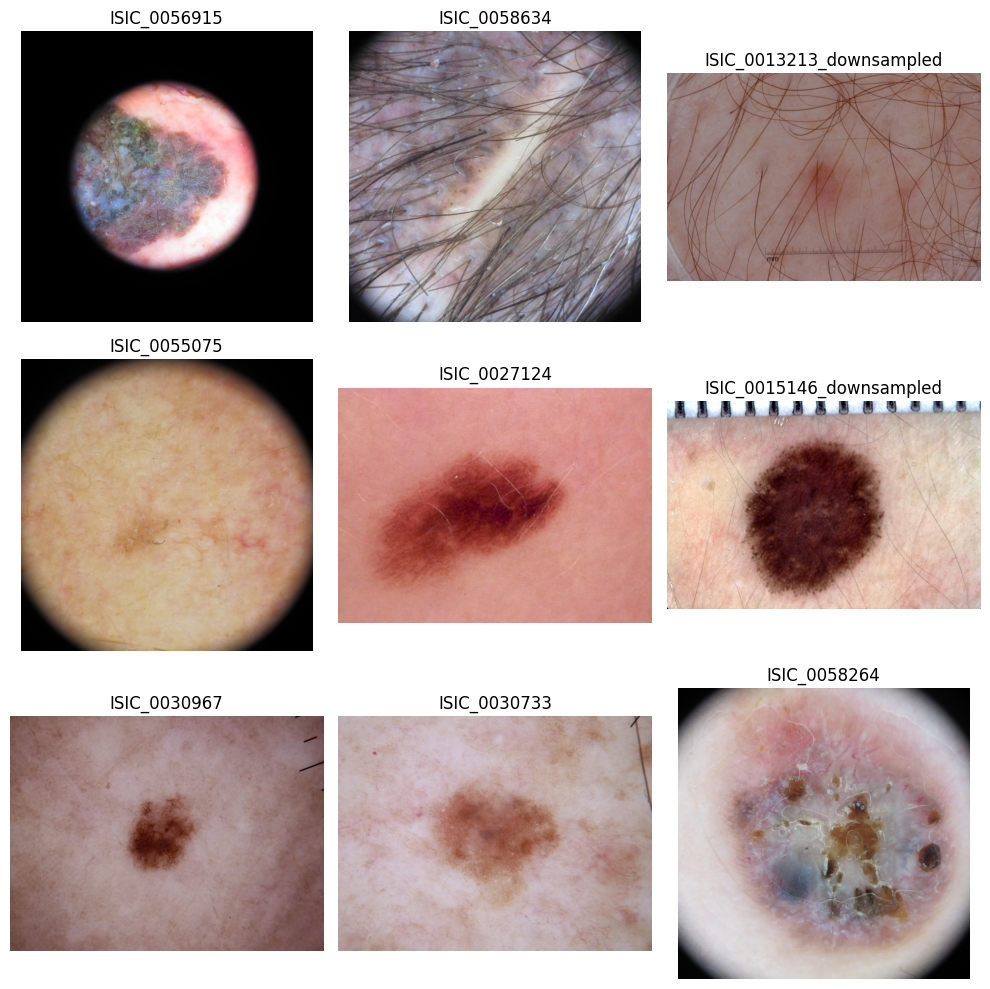

In [ ]:
# Add full path to DataFrame
labels_df['path'] = labels_df['image'].apply(lambda x: os.path.join(image_dir, x + '.jpg'))

# Keep only rows where image file exists
labels_df = labels_df[labels_df['path'].apply(os.path.exists)]

# Now safely sample
sample_images = labels_df['image'].sample(9, random_state=42).values

# Preview
plt.figure(figsize=(10, 10))
for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(image_dir, img_name + '.jpg')
    image = Image.open(img_path)
    plt.subplot(3, 3, idx + 1)
    plt.imshow(image)
    plt.title(img_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 7. Class Distribution and Imbalance Visualization

Understanding the class distribution is essential for medical datasets like ISIC 2019, where class imbalance can severely impact model performance. In this dataset, some classes (e.g., 'NV') dominate while others (e.g., 'DF', 'VASC') are underrepresented.


<ipython-input-7-1135c524a9f1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_sums.index, y=label_sums.values, palette="Set2")


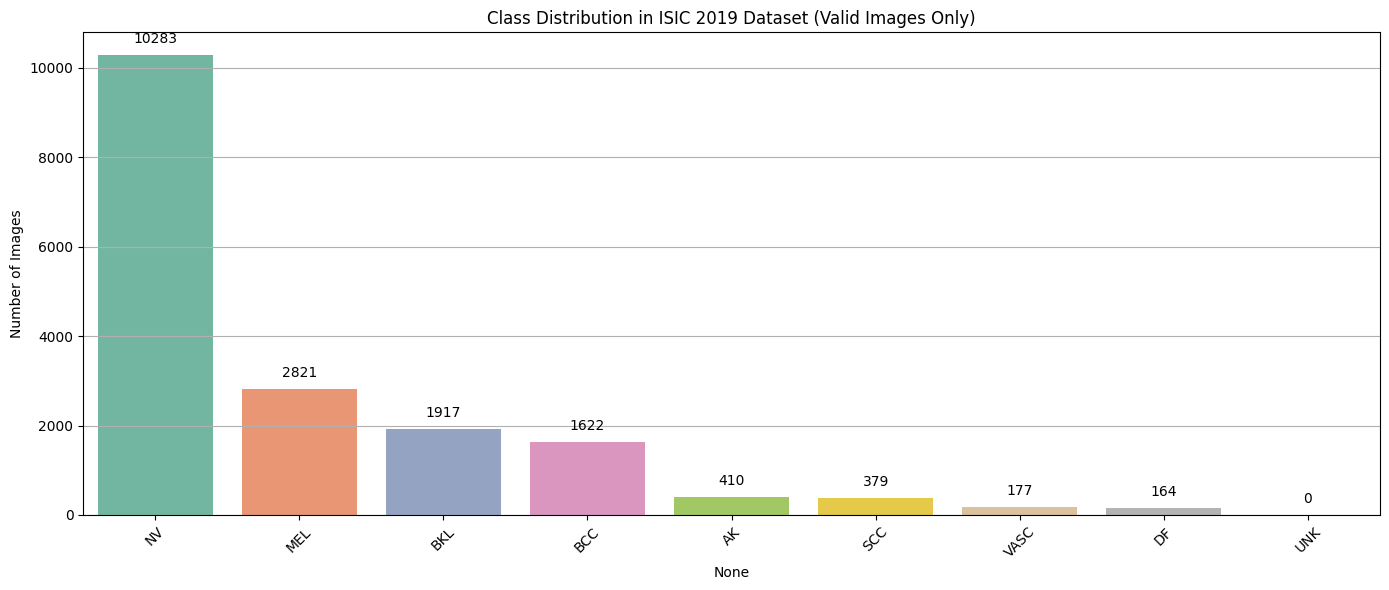

In [ ]:
# Get only class columns
class_names = [col for col in labels_df.columns if col not in ['image', 'path', 'label']]

# Recompute class distribution using only valid images
label_sums = labels_df[class_names].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=label_sums.index, y=label_sums.values, palette="Set2")
plt.title("Class Distribution in ISIC 2019 Dataset (Valid Images Only)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add count labels
for i, count in enumerate(label_sums.values):
    ax.text(i, count + 200, int(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Handling Class Imbalance

Due to the heavily imbalanced class distribution, we apply class weights during model training. This helps the loss function penalize underrepresented classes more, improving the model's ability to detect rare lesion types.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

# Get only class columns
class_names = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
labels = labels_df[class_names]  # Only 0/1 class label columns

# Convert one-hot encoded to single label per row
y_flat = labels.idxmax(axis=1)  # Get the class name where value is 1

# Encode class names to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y_flat)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)

# Map back to class labels
class_weight_dict = {label: weight for label, weight in zip(le.classes_, class_weights)}

# Display
print("Class Weights for Model Training:")
for k, v in class_weight_dict.items():
    print(f"{k}: {v:.4f}")

Class Weights for Model Training:
AK: 5.4186
BCC: 1.3697
BKL: 1.1589
DF: 13.5465
MEL: 0.7875
NV: 0.2160
SCC: 5.8618
VASC: 12.5516


## 9. Preprocessing and Data Augmentation

To prepare the dermoscopic images for deep learning models, preprocessing steps are applied including resizing, normalization, and augmentation. These steps improve the generalization capability of the model and reduce overfitting. All images will be resized to a consistent shape (224x224) and pixel values scaled to [0, 1]. Data augmentation will include flipping, zoom, rotation, and brightness adjustments.

In [ ]:
# Set target image size for model input
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Add 'path' column for image location
labels_df['path'] = labels_df['image'].apply(lambda x: os.path.join(image_dir, x + '.jpg'))

# Filter only rows where the image file exists
labels_df = labels_df[labels_df['path'].apply(os.path.exists)]

# Define your class label columns manually or reuse
class_names = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

# Assign single-label column from one-hot encoded labels
labels_df['label'] = labels_df[class_names].idxmax(axis=1)

# Perform stratified split
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    labels_df,
    test_size=0.3,
    stratify=labels_df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 12441
Validation samples: 2666
Test samples: 2666


In [ ]:
# Downsample training set to 50%
train_df_downsampled = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42)).reset_index(drop=True)

print(f"Original training samples: {len(train_df)}")
print(f"Downsampled training samples: {len(train_df_downsampled)}")

Original training samples: 12441
Downsampled training samples: 6222


<ipython-input-10-3dd3741654c6>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_downsampled = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42)).reset_index(drop=True)


In [ ]:
# Image Data Generator with Augmentation for Training, and Normalization for Validation/Test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_downsampled,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 6222 validated image filenames belonging to 8 classes.
Found 2666 validated image filenames belonging to 8 classes.
Found 2666 validated image filenames belonging to 8 classes.


## 10. Train-Test-Validation Summary

To ensure model fairness and avoid overfitting, the dataset is split into training, validation, and test sets in a stratified manner. Each set maintains class balance. This section visualizes the class distribution across the three subsets.

<ipython-input-12-80831159c63e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


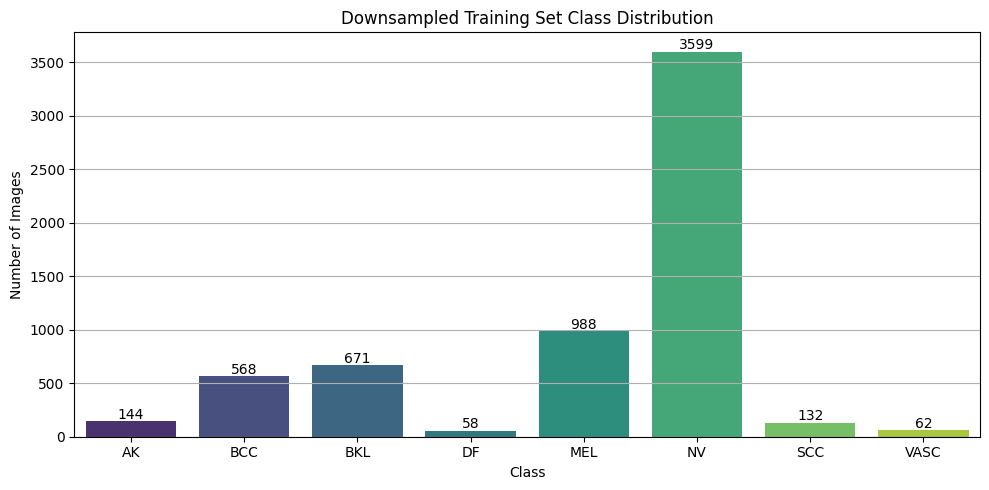

<ipython-input-12-80831159c63e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


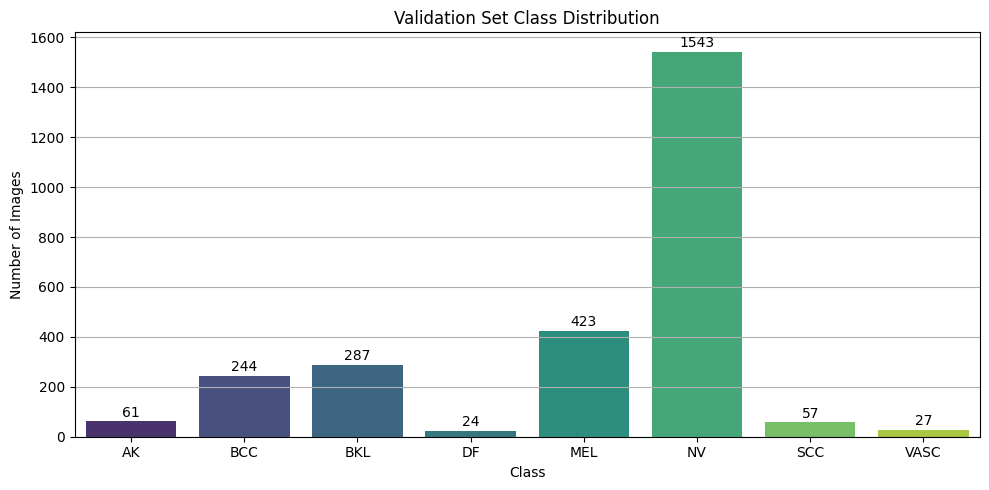

<ipython-input-12-80831159c63e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


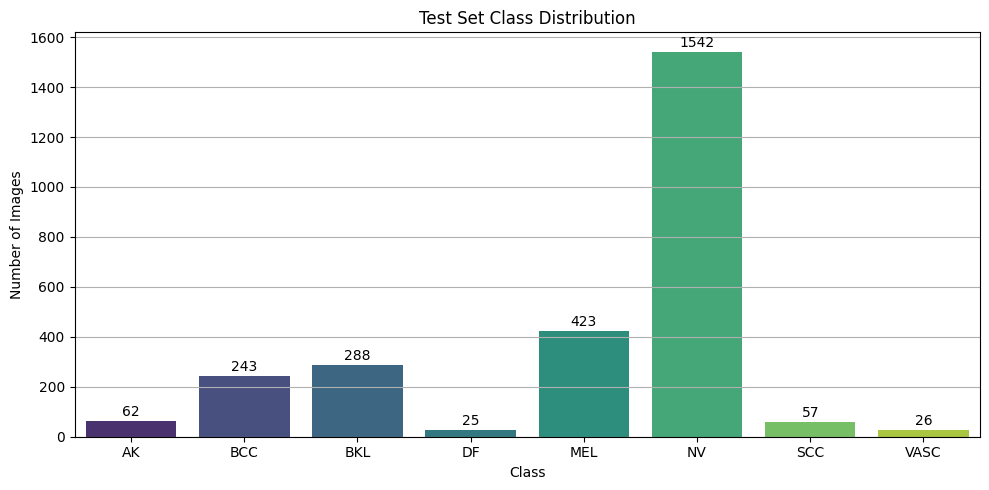

In [ ]:
def plot_split_distribution(df, title):
    class_counts = df['label'].value_counts().sort_index()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xlabel("Class")
    for i, v in enumerate(class_counts.values):
        plt.text(i, v + 20, str(v), ha='center')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

plot_split_distribution(train_df_downsampled, "Downsampled Training Set Class Distribution")
plot_split_distribution(val_df, "Validation Set Class Distribution")
plot_split_distribution(test_df, "Test Set Class Distribution")

## 11. Build Baseline Model: ResNet-50

A ResNet-50 model pre-trained on ImageNet was fine-tuned with a custom head for multi-class classification. During training, class imbalance was addressed using computed class weights. The model achieved ~57% validation accuracy but began to overfit after a few epochs, as indicated by rising validation loss despite improving training accuracy.

This suggests that ResNet-50 alone may not be sufficient to handle the complex variations in dermoscopic features and class imbalance present in the ISIC 2019 dataset. Hence, a more expressive model is necessary, leading to the next section on developing a hybrid MobileNet + Vision Transformer (ViT) model.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import numpy as np

# Define input shape
input_shape = (224, 224, 3)
num_classes = np.max(train_generator.classes) + 1

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

"""
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
"""

"""
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
"""
# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model
model_resnet = Model(inputs=base_model.input, outputs=output)
model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,642,952 (94.01 MB)

 Trainable params: 1,054,216 (4.02 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

### Training ResNet-50 Baseline with EarlyStopping and ModelCheckpoint

To improve model generalization, early stopping is used to halt training when validation loss stops improving. The best model (lowest val_loss) is saved using ModelCheckpoint.

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Checkpoint and EarlyStopping
checkpoint_path = '/content/drive/MyDrive/ISIC_2019/resnet50_downsampled.keras'

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.1439 - loss: 2.8017 
Epoch 1: val_loss improved from inf to 1.63605, saving model to /content/drive/MyDrive/ISIC_2019/resnet50_downsampled.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 6460s 33s/step - accuracy: 0.1439 - loss: 2.8006 - val_accuracy: 0.5758 - val_loss: 1.6360
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.2118 - loss: 2.2732
Epoch 2: val_loss improved from 1.63605 to 1.49040, saving model to /content/drive/MyDrive/ISIC_2019/resnet50_downsampled.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 161s 822ms/step - accuracy: 0.2120 - loss: 2.2728 - val_accuracy: 0.5728 - val_loss: 1.4904
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.2918 - loss: 2.0258
Epoch 3: val_loss improved from 1.49040 to 1.37130, saving model to /content/drive/MyDrive/ISIC_2019/resnet50_downsampled.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 162s 829ms/step - accuracy: 0.2919 - loss: 2.0255 - val_accuracy: 0.5784 - val_loss: 1.3713
Epoch 

## Reload model to resume training from checkpoint

In [ ]:
from tensorflow.keras.models import load_model

model_resnet = load_model('/content/drive/MyDrive/ISIC_2019/resnet50_downsampled.keras')

# Continue training
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # you can reduce this to remaining epochs
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict
)


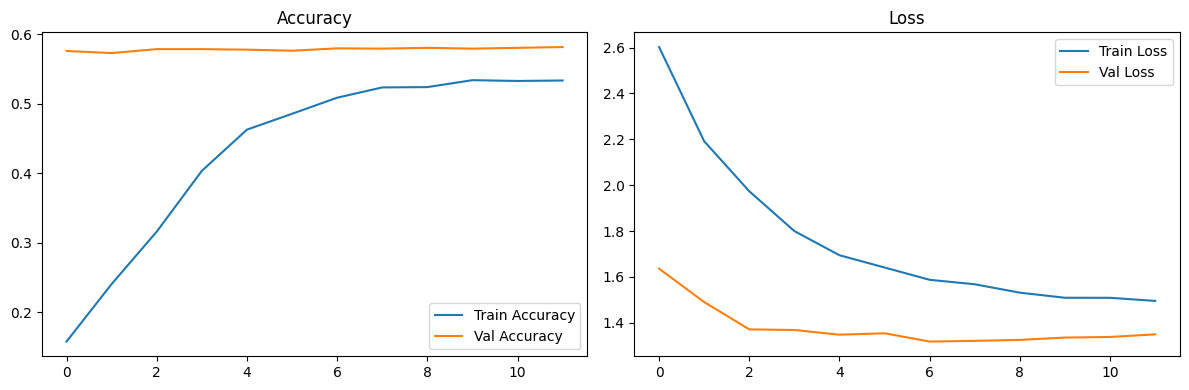

In [ ]:
# Plot Accuracy and Loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.tight_layout()
    plt.show()

plot_history(history_resnet)

## 12. Build Hybrid Model: MobileNet + Vision Transformer (ViT)

This hybrid model combines the lightweight convolutional feature extraction of MobileNetV2 with the global attention capabilities of a Vision Transformer. MobileNetV2 captures local texture patterns, while ViT handles long-range dependencies and spatial relations in dermoscopic images.

In [ ]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense, Layer, GlobalAveragePooling1D, Add
from tensorflow.keras import layers

def transformer_block(inputs, num_heads=4, ff_dim=128, dropout=0.1):
    # Normalization and attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x, x)
    x = Add()([attention_output, inputs])  # Skip connection
    x = Dropout(dropout)(x)

    # Feed-forward network
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation='relu')(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([x, y])

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation


input_shape = (224, 224, 3)
num_classes = 8  # or use: len(class_names)

# MobileNetV2 base
base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
base_model.trainable = False  # Freeze CNN base

# Feature extraction
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# Prepare for ViT
x = Reshape((1, x.shape[-1]))(x)  # Convert to (batch, sequence, features)

# Transformer block
x = transformer_block(x, num_heads=4, ff_dim=128)
x = GlobalAveragePooling1D()(x)  # Collapse back to 1D


"""
# Dense layers with BatchNormalization
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)  # normalize before activation
x = Activation('relu')(x)
x = Dropout(0.3)(x)
"""

# Dense layers
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)  # normalize before activation
x = Activation('relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Compile model
model_hybrid = Model(inputs=inputs, outputs=outputs)
model_hybrid.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_hybrid.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer_6[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 1280)        │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 1, 1280)        │          2,560 │ reshape_2[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 1, 1280)        │     26,231,040 │ layer_normalization_4… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 1, 1280)        │              0 │ multi_head_attention_… │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 1, 1280)        │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 1, 1280)        │          2,560 │ dropout_10[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1, 128)         │        163,968 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1, 1280)        │        165,120 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 1, 1280)        │              0 │ dropout_10[0][0],      │
│                           │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 1280)           │              0 │ add_5[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 1280)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 128)            │        163,968 │ dropout_11[0][0]       │
├──────────────────────

 Total params: 28,988,744 (110.58 MB)

 Trainable params: 26,730,504 (101.97 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

## 1. Checkpoint Saving + EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save the best MobileNet-ViT model
hybrid_ckpt_path = '/content/drive/MyDrive/ISIC_2019/hybrid_mobilenet_vit_best.keras'

early_stop_hybrid = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

hybrid_ckpt = ModelCheckpoint(
    filepath=hybrid_ckpt_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

## 2. Training the Model

In [ ]:
history_hybrid = model_hybrid.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop_hybrid, hybrid_ckpt],
    class_weight=class_weight_dict
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.3669 - loss: 2.1227
Epoch 1: val_loss improved from inf to 1.14474, saving model to /content/drive/MyDrive/ISIC_2019/hybrid_mobilenet_vit_best.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 189s 895ms/step - accuracy: 0.3675 - loss: 2.1209 - val_accuracy: 0.6545 - val_loss: 1.1447
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.6000 - loss: 1.3291
Epoch 2: val_loss improved from 1.14474 to 1.05402, saving model to /content/drive/MyDrive/ISIC_2019/hybrid_mobilenet_vit_best.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 162s 830ms/step - accuracy: 0.6001 - loss: 1.3288 - val_accuracy: 0.6677 - val_loss: 1.0540
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.6220 - loss: 1.1992
Epoch 3: val_loss did not improve from 1.05402
195/195 ━━━━━━━━━━━━━━━━━━━━ 161s 828ms/step - accuracy: 0.6221 - loss: 1.1989 - val_accuracy: 0.6425 - val_loss: 1.1295
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy

## 3. Plot Accuracy and Loss

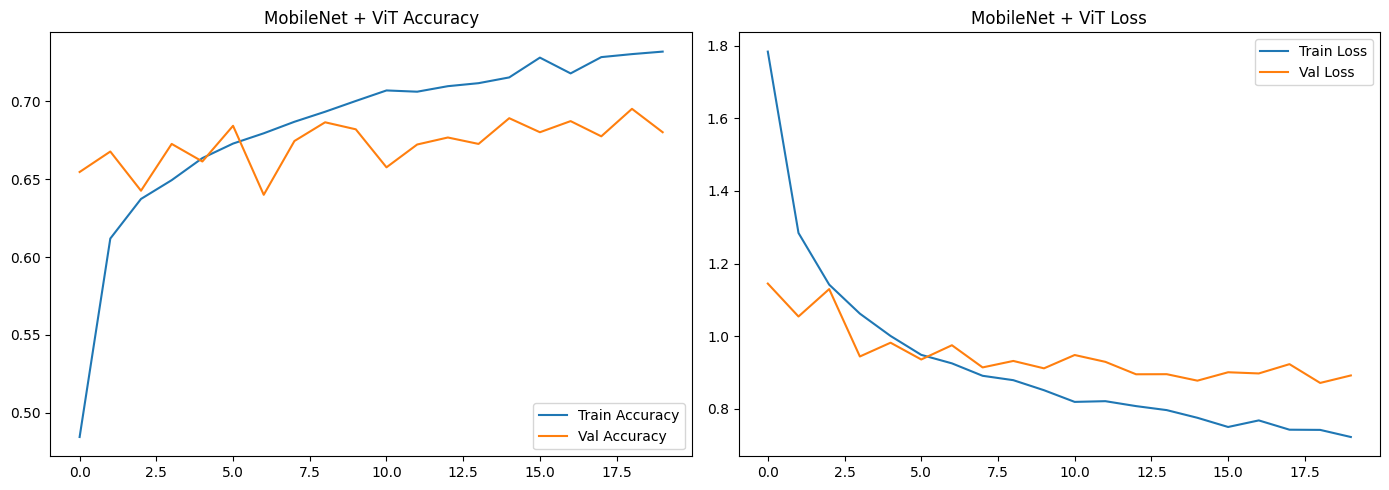

In [ ]:
def plot_history(history, model_name="Hybrid Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Loss')

    plt.tight_layout()
    plt.show()

plot_history(history_hybrid, model_name="MobileNet + ViT")

## 13. Build Comparative Models: Inception & ShuffleNet

To benchmark the hybrid model's performance, we fine-tuned two additional convolutional neural networks: InceptionV3 and ShuffleNet. These models are pre-trained on ImageNet and modified with a custom classification head for 8-class skin lesion classification. Their results help validate whether transformer-based hybrids offer significant advantages over traditional CNNs.


## Model 1: InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Activation

input_shape = (224, 224, 3)
num_classes = 8

# Load base
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
base_inception.trainable = False  # freeze layers

# Build model
inputs = Input(shape=input_shape)
x = base_inception(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_inception = Model(inputs, outputs)
model_inception.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_inception.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_95 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,330,408 (85.18 MB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

## Training InceptionV3

In [ ]:
checkpoint_path_incep = '/content/drive/MyDrive/ISIC_2019/inception_best_model.keras'

early_stop_incep = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint_incep = ModelCheckpoint(checkpoint_path_incep, monitor='val_loss', save_best_only=True, verbose=1)

history_incep = model_inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop_incep, checkpoint_incep],
    class_weight=class_weight_dict
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.2824 - loss: 2.0516
Epoch 1: val_loss improved from inf to 1.33419, saving model to /content/drive/MyDrive/ISIC_2019/inception_best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 204s 962ms/step - accuracy: 0.2831 - loss: 2.0501 - val_accuracy: 0.5908 - val_loss: 1.3342
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.5710 - loss: 1.3364
Epoch 2: val_loss improved from 1.33419 to 1.11750, saving model to /content/drive/MyDrive/ISIC_2019/inception_best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 160s 819ms/step - accuracy: 0.5710 - loss: 1.3363 - val_accuracy: 0.6497 - val_loss: 1.1175
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.5882 - loss: 1.2232
Epoch 3: val_loss improved from 1.11750 to 1.10513, saving model to /content/drive/MyDrive/ISIC_2019/inception_best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 159s 814ms/step - accuracy: 0.5882 - loss: 1.2231 - val_accuracy: 0.6414 - val_loss: 

## Model 2: ShuffleNet (via EfficientNetB0 as Proxy)
Unfortunately, ShuffleNet is not available in tf.keras.applications. As an alternative:

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_effnet.trainable = False

# Build model
inputs = Input(shape=input_shape)
x = base_effnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)


model_effnet = Model(inputs, outputs)
model_effnet.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_effnet.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_96 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,380,587 (16.71 MB)

 Trainable params: 330,504 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

## Training EfficientNet

In [ ]:
checkpoint_path_effnet = '/content/drive/MyDrive/ISIC_2019/efficientnet_best_model.keras'

early_stop_effnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint_effnet = ModelCheckpoint(checkpoint_path_effnet, monitor='val_loss', save_best_only=True, verbose=1)

history_effnet = model_effnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop_effnet, checkpoint_effnet],
    class_weight=class_weight_dict
)


Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.2784 - loss: 2.0285
Epoch 1: val_loss improved from inf to 2.03113, saving model to /content/drive/MyDrive/ISIC_2019/efficientnet_best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.2789 - loss: 2.0275 - val_accuracy: 0.1077 - val_loss: 2.0311
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.5071 - loss: 1.5956
Epoch 2: val_loss improved from 2.03113 to 1.85496, saving model to /content/drive/MyDrive/ISIC_2019/efficientnet_best_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 158s 809ms/step - accuracy: 0.5071 - loss: 1.5954 - val_accuracy: 0.5788 - val_loss: 1.8550
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.5220 - loss: 1.5273
Epoch 3: val_loss did not improve from 1.85496
195/195 ━━━━━━━━━━━━━━━━━━━━ 158s 812ms/step - accuracy: 0.5220 - loss: 1.5272 - val_accuracy: 0.5788 - val_loss: 1.9114
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.531

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Loss')

    plt.tight_layout()
    plt.show()

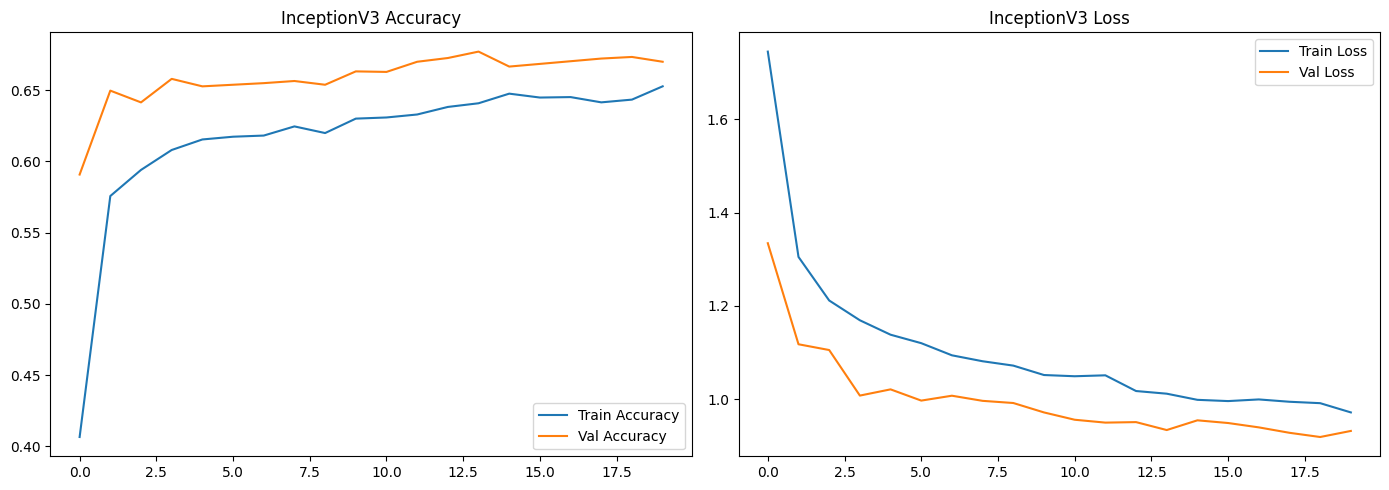

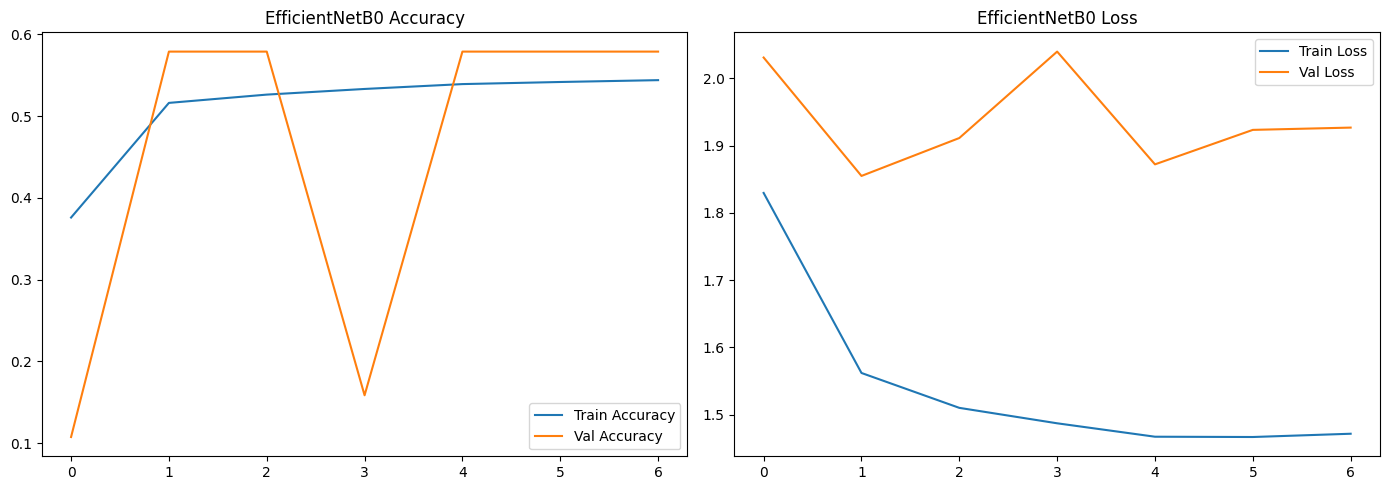

In [ ]:
plot_history(history_incep, model_name="InceptionV3")
plot_history(history_effnet, model_name="EfficientNetB0")

## 14. Model Evaluation & Metrics

After training, the hybrid model is evaluated on the test set using multiple metrics: Accuracy, Precision, Recall, F1-score, AUC-ROC, and Confusion Matrix. This provides a deeper understanding of the model's ability to generalize and handle class imbalance.


## 1. Evaluate on Test Set

In [ ]:
loss, accuracy = model_hybrid.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 1783s 21s/step - accuracy: 0.6860 - loss: 0.9040
Test Accuracy: 0.6842


## 2. Generate Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get ground truth labels and predictions
y_true = test_generator.classes
y_pred_probs = model_hybrid.predict(test_generator)
y_pred = y_pred_probs.argmax(axis=1)

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 362ms/step
              precision    recall  f1-score   support

          AK       0.32      0.16      0.22        62
         BCC       0.53      0.52      0.53       243
         BKL       0.41      0.37      0.39       288
          DF       0.00      0.00      0.00        25
         MEL       0.53      0.41      0.46       423
          NV       0.78      0.90      0.84      1542
         SCC       0.42      0.14      0.21        57
        VASC       0.67      0.62      0.64        26

    accuracy                           0.68      2666
   macro avg       0.46      0.39      0.41      2666
weighted avg       0.65      0.68      0.66      2666



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3. Confusion Matrix

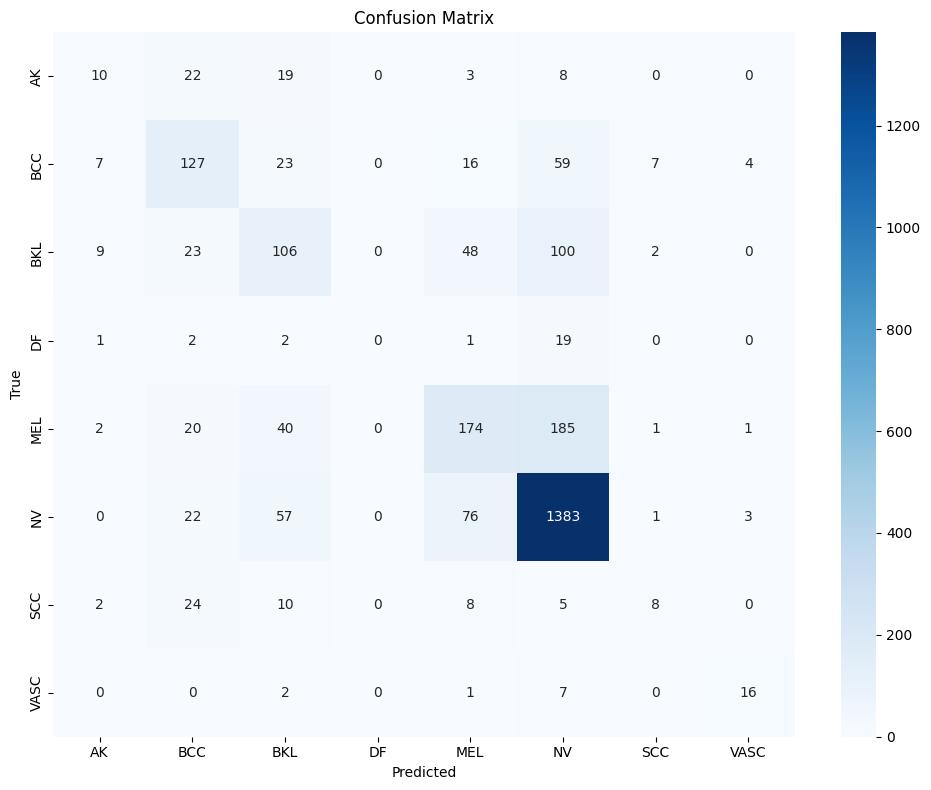

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## 4. AUC-ROC for Each Class

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize true labels for multiclass AUC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))

# AUC per class
auc_score = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_score:.4f}")

Macro-Averaged AUC-ROC: 0.8812


## 15. Grad-CAM & Interpretability

Grad-CAM (Gradient-weighted Class Activation Mapping) helps visualize which parts of an image contributed most to the model’s decision, offering insight into the reasoning process of the hybrid model.

In [ ]:
print("ResNet shape =", model_resnet.input_shape)
print("Inception shape =", model_inception.input_shape)
print("EffNet shape =", model_effnet.input_shape)
print("Hybrid shape =", model_hybrid.input_shape)

ResNet shape = (None, 224, 224, 3)
Inception shape = (None, 224, 224, 3)
EffNet shape = (None, 224, 224, 3)
Hybrid shape = (None, 224, 224, 3)



Processing RESNET...
Using ResNet visualization approach
✅ Finished processing RESNET

Processing INCEPTION...
Using Inception visualization approach


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4083']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Finished processing INCEPTION

Processing EFFICIENTNET...
Using EfficientNet visualization approach


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4394']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Finished processing EFFICIENTNET

Processing HYBRID...
Using Hybrid/MobileNet visualization approach


<ipython-input-129-449ffffcb23c>:200: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = tf.keras.applications.MobileNetV2(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4632']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Finished processing HYBRID


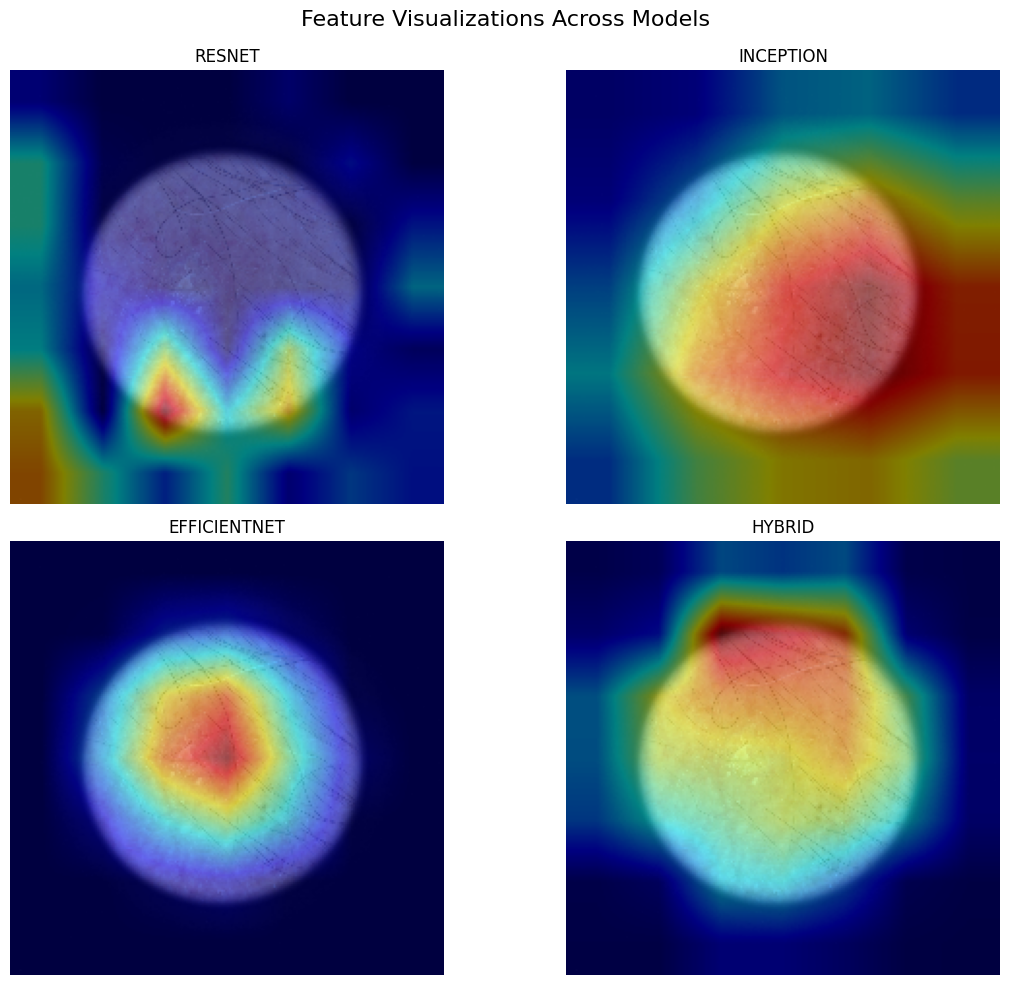

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

def get_img_array(img_path, model_type='resnet'):
    """Preprocess an image for different model architectures"""
    target_size = (224, 224)
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img)

    # Apply model-specific preprocessing
    if model_type == 'resnet':
        arr = resnet_preprocess(arr)
    elif model_type == 'inception':
        arr = inception_preprocess(arr)
    elif model_type == 'efficientnet':
        arr = efficientnet_preprocess(arr)
    elif model_type == 'mobilenet':
        arr = mobilenet_preprocess(arr)

    return np.expand_dims(arr, axis=0)

def resnet_visualization(model, img_array, img_path):
    """Specific visualization approach for ResNet models"""
    try:
        # Using the conv5_block3_out layer which works well for ResNet
        layer_name = 'conv5_block3_out'
        last_conv_model = tf.keras.models.Model(
            inputs=model.input,
            outputs=model.get_layer(layer_name).output
        )

        # Get model prediction for class index
        preds = model.predict(img_array, verbose=0)
        class_idx = np.argmax(preds[0])

        # Get activations from last conv layer
        last_conv_output = last_conv_model.predict(img_array, verbose=0)

        # Create a Grad-CAM like visualization
        with tf.GradientTape() as tape:
            last_conv_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
            iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_model.output])
            model_out, last_conv_output = iterate(img_array)
            class_out = model_out[:, class_idx]

        grads = tape.gradient(class_out, last_conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_output = last_conv_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()

        for i in range(pooled_grads.shape[0]):
            last_conv_output[:, :, i] *= pooled_grads[i]

        heatmap = np.mean(last_conv_output, axis=-1)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        # Create visualization
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))

        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(img, 0.5, heatmap_colored, 0.5, 0)

        return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB), True

    except Exception as e:
        print(f"ResNet visualization error: {e}")
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

def inception_visualization(model, img_array, img_path):
    """Specific visualization approach for Inception models"""
    try:
        # First get the prediction from the full model
        preds = model.predict(img_array, verbose=0)
        class_idx = np.argmax(preds[0])

        # We need to create a separate model for the inception_v3 base
        base_model = None
        for layer in model.layers:
            if 'inception' in layer.name.lower():
                base_model = layer
                break

        if base_model is None:
            print("Could not find InceptionV3 base model")
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

        # Create a model using just the base InceptionV3
        # CRITICAL: We need to use a NEW input tensor for this model
        # instead of trying to connect to the existing model
        input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))

        # Create a new standalone inception model
        inception_model = tf.keras.applications.InceptionV3(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor
        )

        # Get the activations from the last mixed layer
        mixed10_layer = inception_model.get_layer('mixed10')
        activations_model = tf.keras.models.Model(
            inputs=inception_model.input,
            outputs=mixed10_layer.output
        )

        # Get activations
        activations = activations_model.predict(img_array, verbose=0)

        # Create a simple heatmap from the activations
        heatmap = np.mean(activations[0], axis=-1)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        # Create visualization
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))

        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(img, 0.5, heatmap_colored, 0.5, 0)

        return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB), True

    except Exception as e:
        print(f"Inception visualization error: {e}")
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

def efficientnet_visualization(model, img_array, img_path):
    """Specific visualization approach for EfficientNet models"""
    try:
        # First get the prediction from the full model
        preds = model.predict(img_array, verbose=0)
        class_idx = np.argmax(preds[0])

        # Create a new EfficientNetB0 model
        input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))
        efficientnet_model = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor
        )

        # Get activations from the top_activation layer
        top_layer = efficientnet_model.get_layer('top_activation')
        activations_model = tf.keras.models.Model(
            inputs=efficientnet_model.input,
            outputs=top_layer.output
        )

        # Get activations
        activations = activations_model.predict(img_array, verbose=0)

        # Create a simple heatmap from the activations
        heatmap = np.mean(activations[0], axis=-1)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        # Create visualization
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))

        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(img, 0.5, heatmap_colored, 0.5, 0)

        return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB), True

    except Exception as e:
        print(f"EfficientNet visualization error: {e}")
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

def hybrid_visualization(model, img_array, img_path):
    """Specific visualization approach for Hybrid models with MobileNetV2 base"""
    try:
        # First get the prediction from the full model
        preds = model.predict(img_array, verbose=0)
        class_idx = np.argmax(preds[0])

        # Create a new MobileNetV2 model
        input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))
        mobilenet_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor
        )

        # Get activations from the last block
        feature_layer = mobilenet_model.get_layer('out_relu')
        activations_model = tf.keras.models.Model(
            inputs=mobilenet_model.input,
            outputs=feature_layer.output
        )

        # Get activations
        activations = activations_model.predict(img_array, verbose=0)

        # Create a simple heatmap from the activations
        heatmap = np.mean(activations[0], axis=-1)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        # Create visualization
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))

        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(img, 0.5, heatmap_colored, 0.5, 0)

        return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB), True

    except Exception as e:
        print(f"Hybrid visualization error: {e}")
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

def model_specific_visualization(model_name, model, img_array, img_path):
    """Apply model-specific visualization approach"""
    print(f"\nProcessing {model_name}...")

    if 'resnet' in model_name.lower():
        print("Using ResNet visualization approach")
        return resnet_visualization(model, img_array, img_path)

    elif 'inception' in model_name.lower():
        print("Using Inception visualization approach")
        return inception_visualization(model, img_array, img_path)

    elif 'efficient' in model_name.lower():
        print("Using EfficientNet visualization approach")
        return efficientnet_visualization(model, img_array, img_path)

    elif 'hybrid' in model_name.lower() or 'mobile' in model_name.lower():
        print("Using Hybrid/MobileNet visualization approach")
        return hybrid_visualization(model, img_array, img_path)

    else:
        # Fallback to ResNet approach
        print(f"Unknown model type: {model_name}, using ResNet approach")
        return resnet_visualization(model, img_array, img_path)

def visualize_all_models(models_info, img_path):
    """Visualize all models using model-specific approaches"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    success_count = 0

    for i, (model_name, model, preprocess) in enumerate(models_info):
        # Preprocess the image for this model
        img_array = get_img_array(img_path, model_type=preprocess)

        # Apply model-specific visualization
        vis_img, success = model_specific_visualization(model_name, model, img_array, img_path)

        if success:
            success_count += 1

        # Display the result
        axes[i].imshow(vis_img)

        # Set title based on success
        title = model_name
        if not success:
            title += " - No Feature Map"

        axes[i].set_title(title)
        axes[i].axis('off')

        print(f"✅ Finished processing {model_name}")

    # Set the overall title based on success count
    if success_count == 4:
        title = "Feature Visualizations Across Models"
    else:
        title = f"Feature Visualizations ({success_count}/4 Models Successful)"

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Define models information
models_info = [
    ('RESNET', model_resnet, 'resnet'),
    ('INCEPTION', model_inception, 'inception'),
    ('EFFICIENTNET', model_effnet, 'efficientnet'),
    ('HYBRID', model_hybrid, 'mobilenet')
]

# Visualize all models
sample_img_path = test_df.sample(1)['path'].values[0]
visualize_all_models(models_info, sample_img_path)

## 16. Prediction Visualization

To better understand the hybrid model’s decision-making, we randomly visualize predictions on images from the test set. Each image shows the true label, the predicted label, and the prediction confidence score. This helps in identifying which classes the model performs well on and where it struggles.


## Visualize Random Predictions

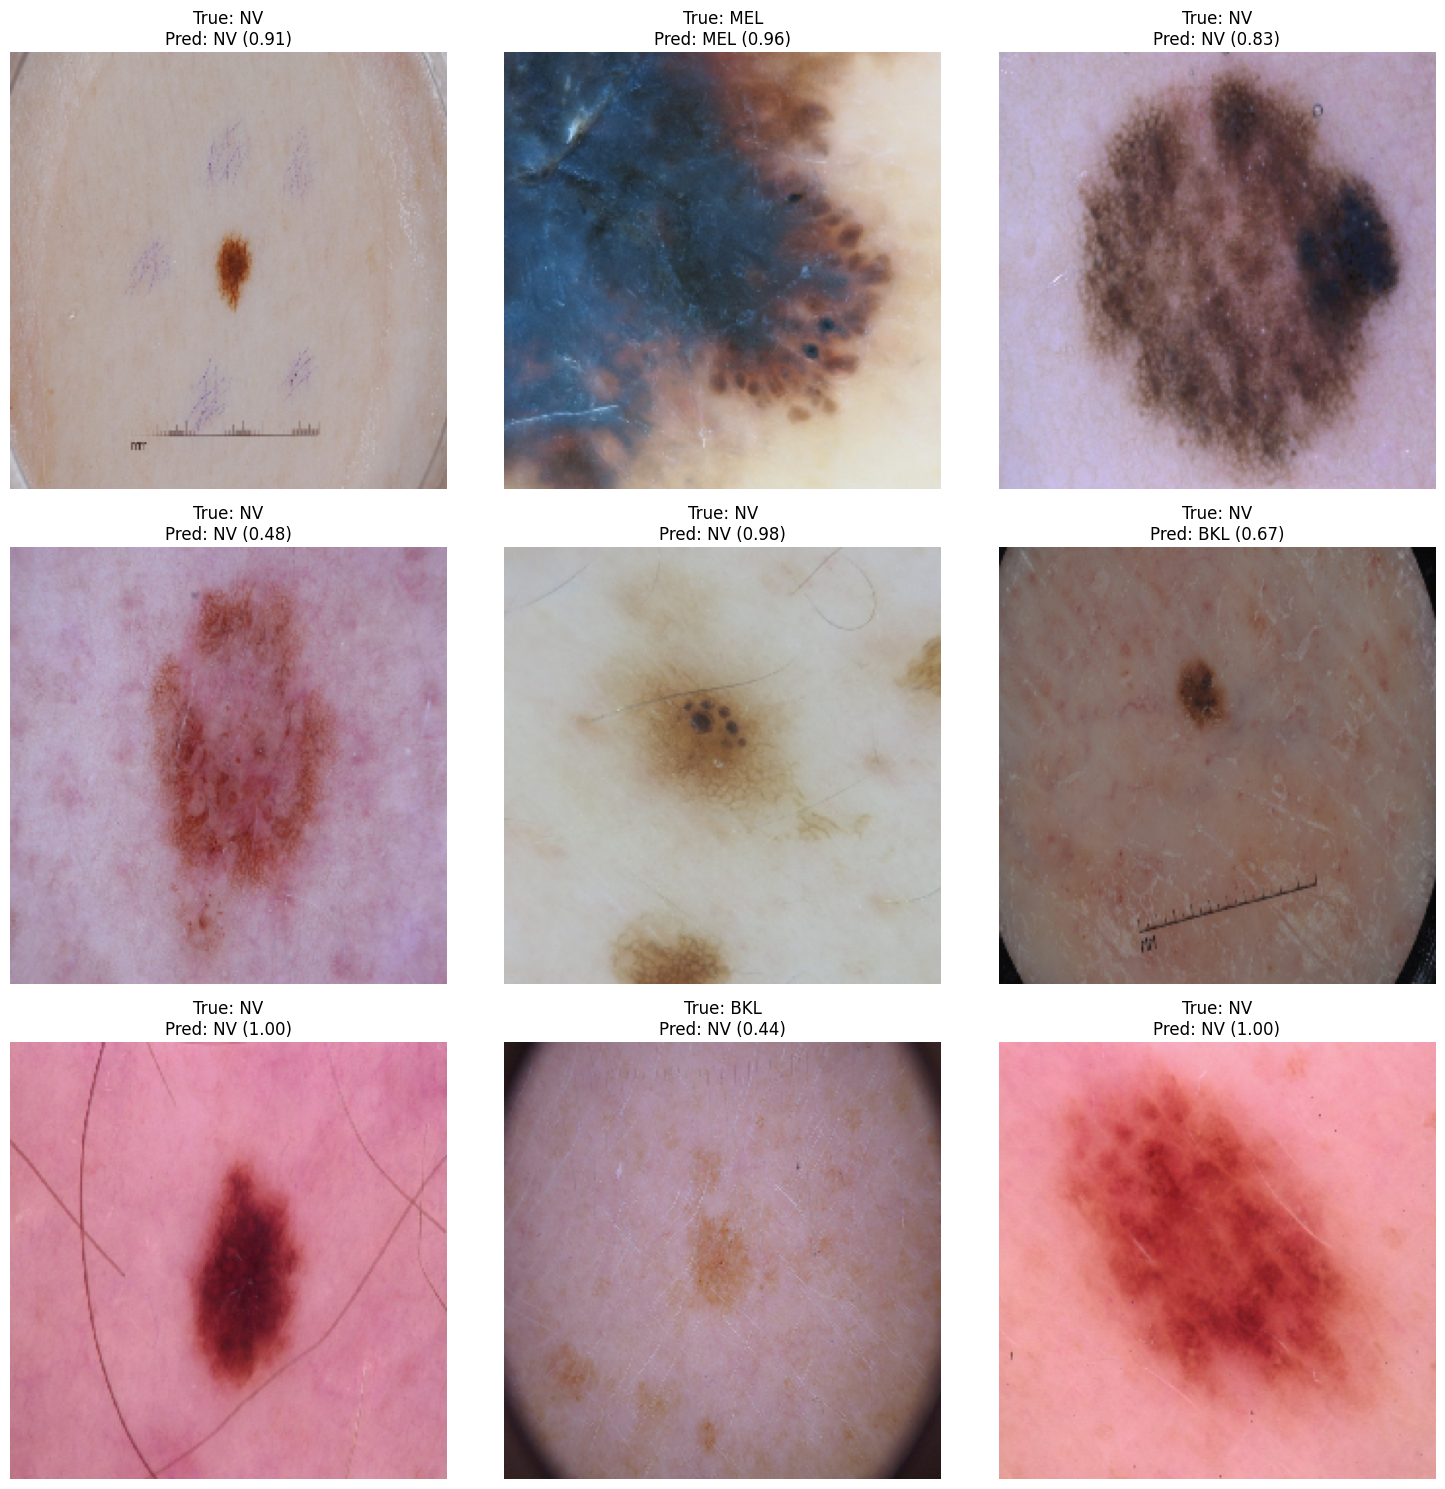

In [ ]:
import random
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load class labels
class_labels = list(test_generator.class_indices.keys())
inv_class_indices = {v: k for k, v in test_generator.class_indices.items()}

# Get a few random indices from test set
random_indices = random.sample(range(len(test_generator.filenames)), 9)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    img_path = os.path.join(image_dir, test_generator.filenames[idx])
    true_label = inv_class_indices[test_generator.classes[idx]]

    # Preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    # Predict
    pred_probs = model_hybrid.predict(img_array_exp, verbose=0)
    pred_class = class_labels[np.argmax(pred_probs)]
    confidence = np.max(pred_probs)

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_class} ({confidence:.2f})")

plt.tight_layout()
plt.show()

## 17. Model Comparison and Discussion

In this section, we compare the performance of all trained models — ResNet-50 (baseline), MobileNet+ViT (hybrid), InceptionV3, and EfficientNetB0. Metrics used for comparison include Accuracy, Precision, Recall, F1-Score, and AUC-ROC. This allows us to assess which architecture generalizes best for multi-class skin lesion classification.

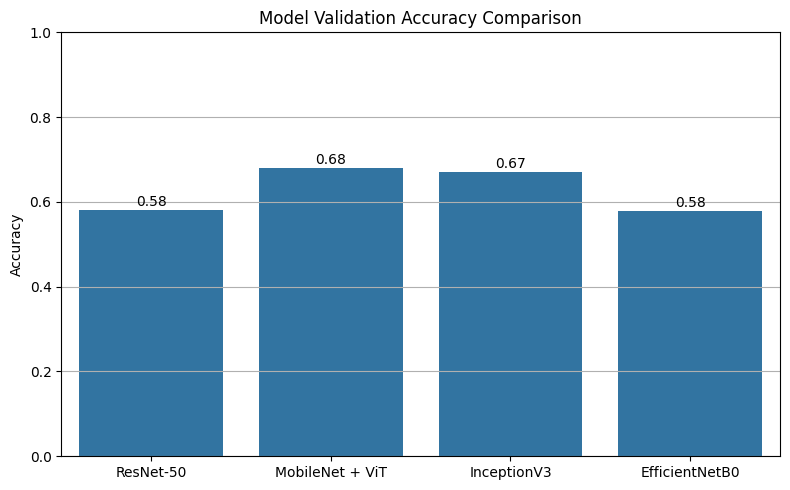

In [ ]:
# Dictionary of final accuracy scores
model_scores = {
    'ResNet-50': history_resnet.history['val_accuracy'][-1],
    'MobileNet + ViT': history_hybrid.history['val_accuracy'][-1],
    'InceptionV3': history_incep.history['val_accuracy'][-1],
    'EfficientNetB0': history_effnet.history['val_accuracy'][-1]
}

# Plot comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()))
plt.title("Model Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(model_scores.values()):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


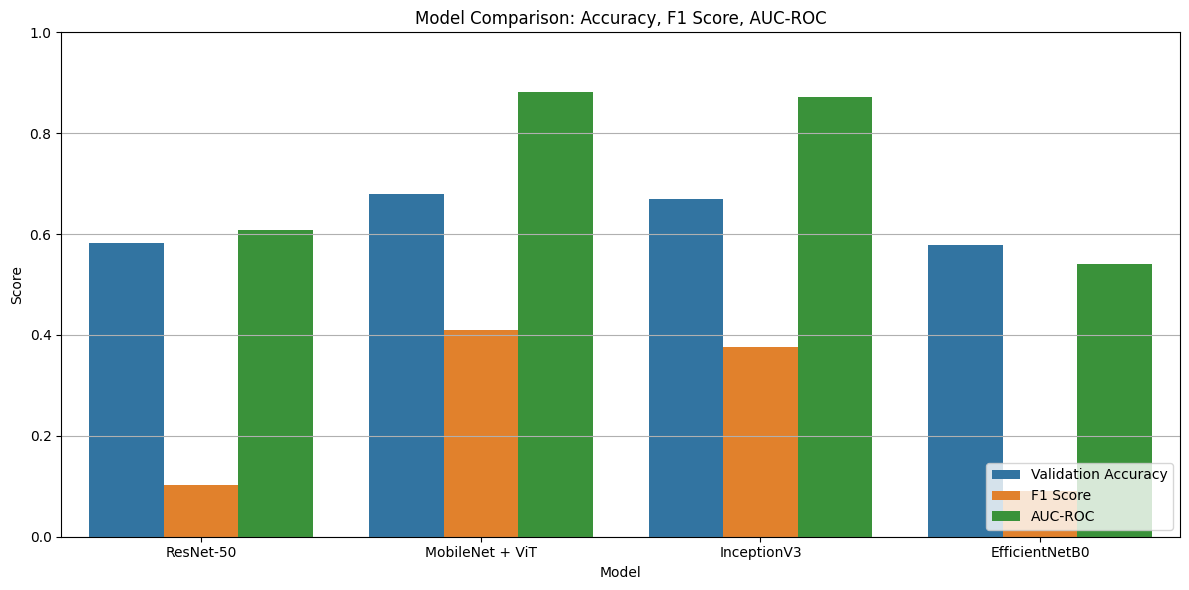

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to get F1 and AUC-ROC
def get_metrics(model, generator):
    y_true = generator.classes
    y_probs = model.predict(generator, verbose=0)
    y_pred = y_probs.argmax(axis=1)

    f1 = f1_score(y_true, y_pred, average='macro')

    y_true_bin = label_binarize(y_true, classes=np.arange(len(generator.class_indices)))
    auc = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

    return f1, auc

# Collect metrics for each model
f1_resnet, auc_resnet = get_metrics(model_resnet, test_generator)
f1_hybrid, auc_hybrid = get_metrics(model_hybrid, test_generator)
f1_incep, auc_incep = get_metrics(model_inception, test_generator)
f1_effnet, auc_effnet = get_metrics(model_effnet, test_generator)

# Build DataFrame for seaborn
import pandas as pd

model_metrics_df = pd.DataFrame({
    'Model': ['ResNet-50', 'MobileNet + ViT', 'InceptionV3', 'EfficientNetB0'],
    'Validation Accuracy': [
        history_resnet.history['val_accuracy'][-1],
        history_hybrid.history['val_accuracy'][-1],
        history_incep.history['val_accuracy'][-1],
        history_effnet.history['val_accuracy'][-1]
    ],
    'F1 Score': [f1_resnet, f1_hybrid, f1_incep, f1_effnet],
    'AUC-ROC': [auc_resnet, auc_hybrid, auc_incep, auc_effnet]
})

# Melt for barplot
melted = model_metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Model', y='Score', hue='Metric')
plt.title("Model Comparison: Accuracy, F1 Score, AUC-ROC")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## 18. Save Models and Wrap-up

All trained models are saved for future reuse and deployment. These models can now be used to make predictions, serve APIs, or be integrated into web-based diagnostic tools. Further fine-tuning or active learning may be applied for performance gains.

In [ ]:
# Save final models manually (if not already saved via checkpoints)
model_resnet.save('/content/drive/MyDrive/ISIC_2019/final_resnet50_model.keras')
model_hybrid.save('/content/drive/MyDrive/ISIC_2019/final_hybrid_model.keras')
model_inception.save('/content/drive/MyDrive/ISIC_2019/final_inception_model.keras')
model_effnet.save('/content/drive/MyDrive/ISIC_2019/final_effnet_model.keras')